In [111]:
from torch.utils.data import Dataset
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils.data import DataLoader
import torch
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import densenet121, DenseNet121_Weights
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Week 5 exercises
### Task 1

In [112]:
class FlowersDataset(Dataset):
    def __init__(self, split='train', transform=None):
        self.base_path = Path.cwd()
        self.flowers_path = self.base_path / Path('flowers_data')
        self.jpg_path = self.flowers_path / Path('jpg')

        self.split_path = Path(f'{split}file.txt')
        self.split_path = self.flowers_path / self.split_path
        self.transform = transform

        self.img_file = pd.read_csv(self.split_path, header=None, sep=' ')
        self.img_paths, self.img_labels = self.img_file[0], self.img_file[1]

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.jpg_path / Path(self.img_paths[idx])
        image = Image.open(img_path).convert('RGB')
        label = int(self.img_labels[idx])
        if self.transform:
            image = self.transform(image)

        return image, label


In [113]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, early_stopping=3, save_path=None):
    model = model.to(device)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    epochs_no_improvement = 0
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train() # set the model into training mode
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # clearing the gradients
            outputs = model(images) # predicting on model
            loss = criterion(outputs, labels)
            loss.backward() # backprop
            optimizer.step() # backprop

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_acc, val_loss = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            if save_path:
                torch.save(model.state_dict(), save_path)
            print(f'Epoch {epoch + 1}/{num_epochs} Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
                  f'Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f} - Best so far')
            best_val_acc = val_acc
            epochs_no_improvement = 0
        else:
            print(f'Epoch {epoch + 1}/{num_epochs} Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
                  f'Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')
            epochs_no_improvement += 1

        if epochs_no_improvement == early_stopping:
            print(f'Early stopping! No improvement over Val Accuracy {val_acc:.4f} over {early_stopping} epochs.')
            break
    
    return train_losses, val_losses, train_accs, val_accs


def evaluate(model, dataloader, criterion):
    model.eval() # setting in evaluation mode
    all_preds, all_labels, all_probs = [], [], []
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

        val_loss = running_loss / len(dataloader)

        all_preds, all_labels, all_probs = torch.cat(all_preds), torch.cat(all_labels), torch.cat(all_probs)
        
        val_acc = accuracy_score(all_labels, all_preds)

        return val_acc, val_loss    

In [114]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [115]:
train_dataset = FlowersDataset(split='train', transform=data_transforms['train'])
val_dataset = FlowersDataset(split='val', transform=data_transforms['val'])
test_dataset = FlowersDataset(split='test')

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [116]:
def plotting(train_vals, val_vals, xlabel, ylabel, title):

    epochs = range(1, len(train_vals) + 1)
    plt.figure(figsize=(6, 5))
    plt.plot(epochs, train_vals, label='train')
    if val_vals:
        plt.plot(epochs, val_vals, label='val')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

Epoch 1/20 Train Loss: 4.4994, Val Loss: 3.9340, Train Accuracy: 0.0522, Val Accuracy: 0.0809 - Best so far
Epoch 2/20 Train Loss: 3.7479, Val Loss: 3.7269, Train Accuracy: 0.0988, Val Accuracy: 0.1397 - Best so far
Epoch 3/20 Train Loss: 3.4756, Val Loss: 3.4974, Train Accuracy: 0.1349, Val Accuracy: 0.1838 - Best so far
Epoch 4/20 Train Loss: 3.2671, Val Loss: 3.2042, Train Accuracy: 0.1590, Val Accuracy: 0.1618
Epoch 5/20 Train Loss: 3.0614, Val Loss: 3.0480, Train Accuracy: 0.2019, Val Accuracy: 0.2557 - Best so far
Epoch 6/20 Train Loss: 2.8390, Val Loss: 2.7762, Train Accuracy: 0.2587, Val Accuracy: 0.2810 - Best so far
Epoch 7/20 Train Loss: 2.5861, Val Loss: 2.6423, Train Accuracy: 0.3227, Val Accuracy: 0.3129 - Best so far
Epoch 8/20 Train Loss: 2.3774, Val Loss: 2.2992, Train Accuracy: 0.3652, Val Accuracy: 0.3832 - Best so far
Epoch 9/20 Train Loss: 2.1469, Val Loss: 2.1059, Train Accuracy: 0.4134, Val Accuracy: 0.4379 - Best so far
Epoch 10/20 Train Loss: 1.9406, Val Loss: 

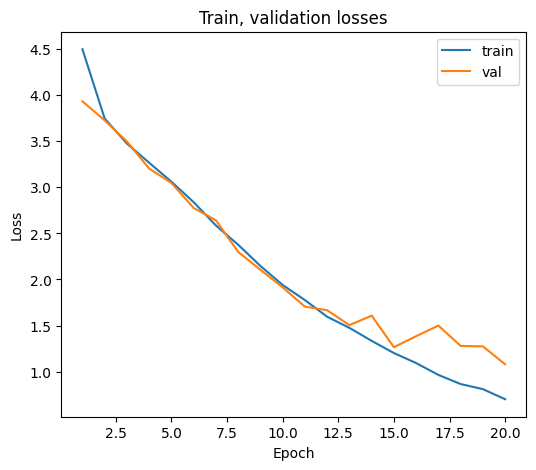

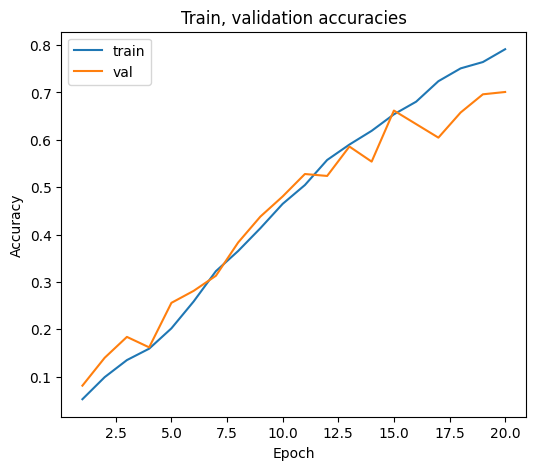

In [117]:
resnet_noweights = resnet34(weights=None)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_noweights.parameters(), lr=0.005)

save_path = Path.cwd() / Path('resnet_noweights.pth')
train_losses, val_losses, train_accs, val_accs = train(resnet_noweights, 
                                                       train_loader=train_dataloader, 
                                                       val_loader=val_dataloader, 
                                                       criterion=criterion, 
                                                       optimizer=optimizer, 
                                                       num_epochs=20, 
                                                       early_stopping=5, 
                                                       save_path=save_path)

plotting(train_losses, val_losses, "Epoch", "Loss", "Train, validation losses")
plotting(train_accs, val_accs, "Epoch", "Accuracy", "Train, validation accuracies")

Epoch 1/20 Train Loss: 2.8558, Val Loss: 1.6688, Train Accuracy: 0.3677, Val Accuracy: 0.5678 - Best so far
Epoch 2/20 Train Loss: 1.1099, Val Loss: 1.2043, Train Accuracy: 0.6947, Val Accuracy: 0.6708 - Best so far
Epoch 3/20 Train Loss: 0.7125, Val Loss: 0.8770, Train Accuracy: 0.8008, Val Accuracy: 0.7598 - Best so far
Epoch 4/20 Train Loss: 0.4909, Val Loss: 0.9106, Train Accuracy: 0.8593, Val Accuracy: 0.7500
Epoch 5/20 Train Loss: 0.4189, Val Loss: 0.7517, Train Accuracy: 0.8801, Val Accuracy: 0.7843 - Best so far
Epoch 6/20 Train Loss: 0.3548, Val Loss: 0.5231, Train Accuracy: 0.8977, Val Accuracy: 0.8587 - Best so far
Epoch 7/20 Train Loss: 0.3056, Val Loss: 0.3985, Train Accuracy: 0.9101, Val Accuracy: 0.8962 - Best so far
Epoch 8/20 Train Loss: 0.2410, Val Loss: 0.6343, Train Accuracy: 0.9258, Val Accuracy: 0.8366
Epoch 9/20 Train Loss: 0.2400, Val Loss: 0.3979, Train Accuracy: 0.9316, Val Accuracy: 0.8962
Epoch 10/20 Train Loss: 0.2250, Val Loss: 0.5523, Train Accuracy: 0.93

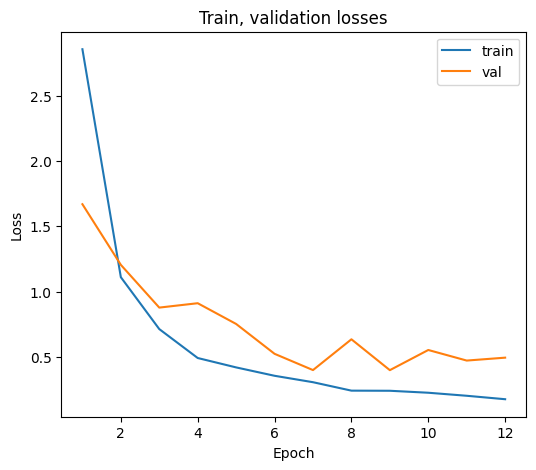

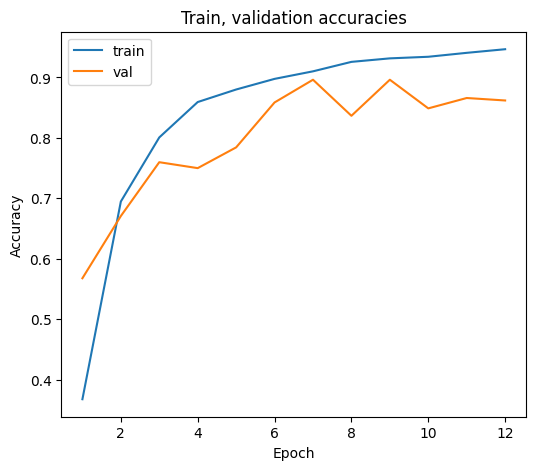

In [120]:
resnet_weights = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_weights.parameters(), lr=0.001)

save_path = Path.cwd() / Path('resnet_weights.pth')
train_losses, val_losses, train_accs, val_accs = train(resnet_weights, 
                                                       train_loader=train_dataloader, 
                                                       val_loader=val_dataloader, 
                                                       criterion=criterion, 
                                                       optimizer=optimizer, 
                                                       num_epochs=20, 
                                                       early_stopping=5, 
                                                       save_path=save_path)

plotting(train_losses, val_losses, "Epoch", "Loss", "Train, validation losses")
plotting(train_accs, val_accs, "Epoch", "Accuracy", "Train, validation accuracies")

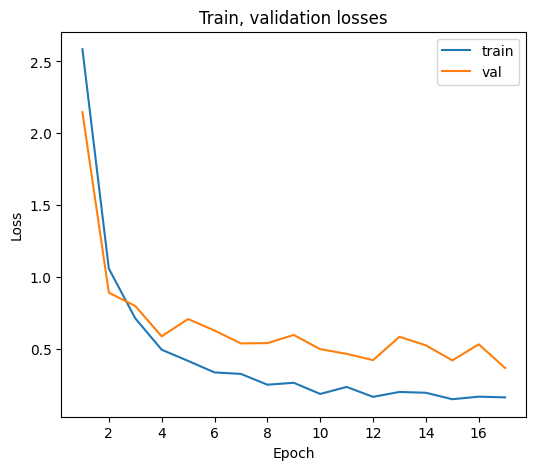

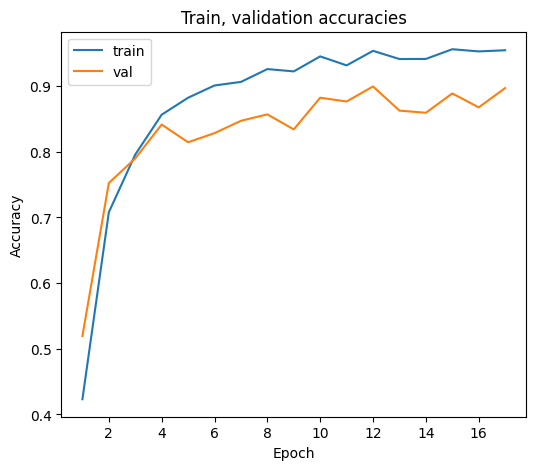

Epoch 1/20 Train Loss: 2.7663, Val Loss: 1.3279, Train Accuracy: 0.4554, Val Accuracy: 0.7639 - Best so far
Epoch 2/20 Train Loss: 0.9950, Val Loss: 0.7032, Train Accuracy: 0.8426, Val Accuracy: 0.8734 - Best so far
Epoch 3/20 Train Loss: 0.6020, Val Loss: 0.5121, Train Accuracy: 0.9047, Val Accuracy: 0.8962 - Best so far
Epoch 4/20 Train Loss: 0.4408, Val Loss: 0.4250, Train Accuracy: 0.9254, Val Accuracy: 0.9150 - Best so far
Epoch 5/20 Train Loss: 0.3559, Val Loss: 0.3981, Train Accuracy: 0.9404, Val Accuracy: 0.9167 - Best so far
Epoch 6/20 Train Loss: 0.2945, Val Loss: 0.3304, Train Accuracy: 0.9522, Val Accuracy: 0.9273 - Best so far
Epoch 7/20 Train Loss: 0.2430, Val Loss: 0.2903, Train Accuracy: 0.9590, Val Accuracy: 0.9363 - Best so far
Epoch 8/20 Train Loss: 0.2196, Val Loss: 0.3050, Train Accuracy: 0.9617, Val Accuracy: 0.9273
Epoch 9/20 Train Loss: 0.1975, Val Loss: 0.2885, Train Accuracy: 0.9624, Val Accuracy: 0.9240
Epoch 10/20 Train Loss: 0.1765, Val Loss: 0.2640, Train 

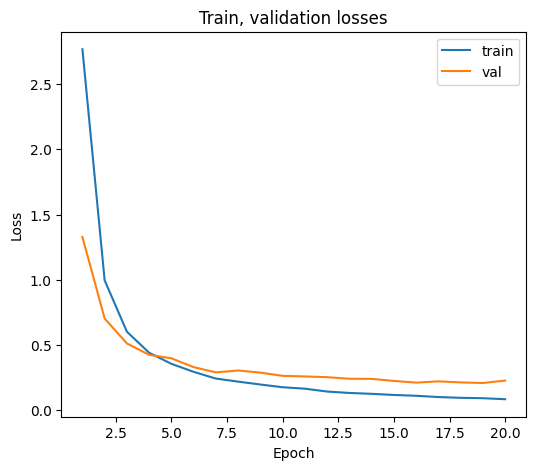

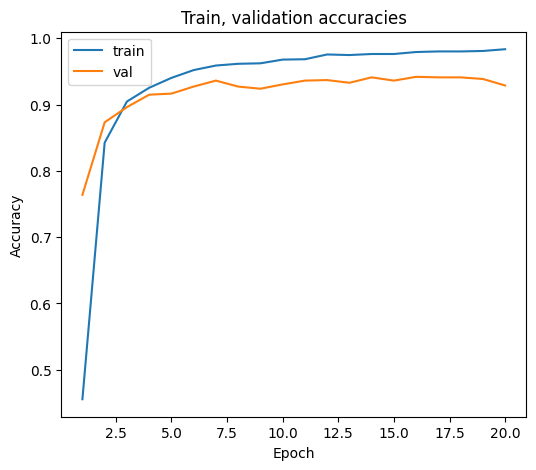

In [119]:
resnet_frozen = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

for param in resnet_frozen.parameters():
    param.requires_grad = False # freezing all layers

num_classes = len(set(train_dataset.img_labels))

resnet_frozen.fc = nn.Linear(resnet_frozen.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_frozen.fc.parameters(), lr=0.001)

save_path = Path.cwd() / Path('resnet_weights.pth')
train_losses, val_losses, train_accs, val_accs = train(resnet_frozen, 
                                                       train_loader=train_dataloader, 
                                                       val_loader=val_dataloader, 
                                                       criterion=criterion, 
                                                       optimizer=optimizer, 
                                                       num_epochs=20, 
                                                       early_stopping=5, 
                                                       save_path=save_path)

plotting(train_losses, val_losses, "Epoch", "Loss", "Train, validation losses")
plotting(train_accs, val_accs, "Epoch", "Accuracy", "Train, validation accuracies")

### Task 2

**Oppgave 1** You are given a 2-dimensional convolution with feature map input size
(78, 84). When using a kernel of size (5, 5) and stride 3 with padding of 2,
what will be the spatial size of the feature map, which is the output of the
convolution? Note that the spatial size does not depend on the number
of input or output channels.

**Svar:** Vi har altså en 2D-matrise med størrelse $(H_{in}, W_{in})$, samt en kjerne som konvolverer over dette $(K_h, K_w)$ med et antall steg (stride), f.eks. `stride=3`. I tillegg til dette kan vi ha padding, eller kantfylling som legges til dette $(P_h, P_w)$. Vi kan da bruke formelen 
\begin{align*}
(H_{\text{out}}, W_{\text{out}}) &= 
\left(
\left\lfloor \frac{H_{\text{in}} + 2P - K}{S} \right\rfloor + 1,\ 
\left\lfloor \frac{W_{\text{in}} + 2P - K}{S} \right\rfloor + 1
\right) \\
&= \left(
\left\lfloor \frac{78 + 2\cdot2 - 5}{3} \right\rfloor + 1,\ 
\left\lfloor \frac{84 + 2\cdot2 - 5}{3} \right\rfloor + 1
\right) \\
&= \left(
\left\lfloor \frac{77}{3} \right\rfloor + 1,\ 
\left\lfloor \frac{83}{3} \right\rfloor + 1
\right) \\
&= (25 + 1,\ 27 + 1) = (26,\ 28)
\end{align*}




**Oppgave 2** You are given a 1-dimensional convolution. When using a kernel of size 9
and stride 3 with padding 1, which spatial input size do you need to have
so that you have a spatial output size of 16?

**Svar**

\begin{align*}
L_{\text{in}} &= (L_{\text{out}} - 1) \cdot S - 2P + K \\
&= (16 - 1) \cdot 3 - 2 \cdot 1 + 9 \\
&= 15 \cdot 3 - 2 + 9 = 45 - 2 + 9 = 52
\end{align*}


**Oppgave 3** You are given a 2-dimensional convolution. When using a kernel of size (3, 5) and stride 2 with padding of 0, what will be the spatial size of the 2 feature map, which spatial input size do you need to have, so that you have a spatial output size of (128, 96)?

\begin{align*}
(H_{\text{in}}, W_{\text{in}}) &= 
\left( (H_{\text{out}} - 1) \cdot S - 2P + K_h,\ 
(W_{\text{out}} - 1) \cdot S - 2P + K_w \right) \\
&= \left( (128 - 1) \cdot 2 - 0 + 3,\ 
(96 - 1) \cdot 2 - 0 + 5 \right) \\
&= (127 \cdot 2 + 3,\ 95 \cdot 2 + 5) \\
&= (254 + 3,\ 190 + 5) \\
&= (257,\ 195)
\end{align*}

### Task 3: Number of trainable parameters

La oss først få litt intuisjon. Si at vi har et bilde, $(3, 32, 32)$, altså med RGB-fargelag på $3$, samt $32$ piksler i hver retning. Og så skal vi bruke 64 filtre, hvert med størrelse $(3, 5, 5)$. Da har hvert filter $$3 \times 5 \times 5 = 75 \text{ vekter} + 1 \text{ bias} = 76 \text{ parametre}$$ Og med 64 slike filtre har vi $$76 \times 64 = 4864 \text{ parametre totalt}$$. Dette gir den generelle formelen $$\text{Antall parametre } = C_{out} \times (C_{in}\times K_h \times K_w + 1)$$

* How many trainable parameters are in a 2-D convolutional layer with input (32, 19, 19), kernel size (7, 7), stride
3, 64 output channels?

Dette gir altså 
\begin{align*}
\text{Antall trenbare parametere} &= C_{\text{out}} \cdot (C_{\text{in}} \cdot K_h \cdot K_w + 1) \\
&= 64 \cdot (32 \cdot 7 \cdot 7 + 1) \\
&= 64 \cdot (1568 + 1) = 64 \cdot 1569 \\
&= 100416
\end{align*}

* a 2-D convolutional layer with input (512, 25, 25), kernel size (1, 1), stride 1, 128 output channels?
\begin{align*}
\text{Antall trenbare parametere} &= C_{\text{out}} \cdot (C_{\text{in}} \cdot K_h \cdot K_w + 1) \\
&= 128 \cdot (512 \cdot 1 \cdot 1 + 1) \\
&= 128 \cdot 513\\
&= 65664
\end{align*}

* How many multiplications and how many additions are performed in the first case above?